In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from Samplers import ISSampler, ABCSampler, MCSampler
from StochasticProcess import RandomWalk
from proposal_distributions import MinimalProposal, SimonsProposal
from prior_distributions import DiscreteUniform
from plotting import plot_mean_trajectories, plot_trajectory_time_evolution

Populating the interactive namespace from numpy and matplotlib


In [2]:
MC_SAMPLES = 2000
POSSIBLE_STEPS = [[-1], [+1]]
STEP_PROBS = np.ones(2)/2
DIMENSIONS = 1
rw = RandomWalk(DIMENSIONS, STEP_PROBS, POSSIBLE_STEPS, n_agents=1, T=100, prior_distribution=DiscreteUniform(DIMENSIONS, -2, 4))
rw.reset()
print('True Starting Position is:{}'.format(rw.x0))

True Starting Position is:[1]


In [3]:
iss = ISSampler(SimonsProposal)
iss_results = iss.solve(rw, MC_SAMPLES)
iss_results.expectation(True), iss_results.variance(True)

/Users/zaf/development/better-sampling/proposal_distributions.py:86: RuntimeWarning: invalid value encountered in true_divide
  sign = w / np.abs(w)
/Users/zaf/development/better-sampling/proposal_distributions.py:89: RuntimeWarning: divide by zero encountered in true_divide
  bias = (sign * self.push_toward - w) * 1. / time_left
/Users/zaf/development/better-sampling/StochasticProcess.py:135: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(self.prior.pdf(self.x_agent))


(0.15535258719859008, 0.10841179703256697)

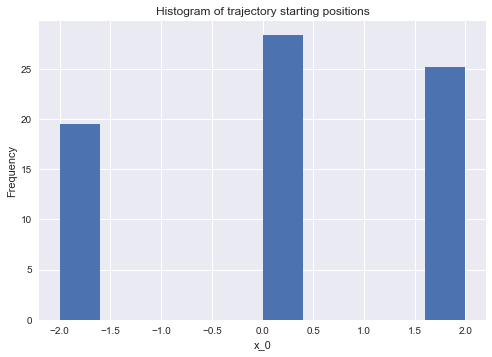

In [4]:
iss_results.plot_distribution()

In [5]:
abc = ABCSampler(2)
abc_results = abc.solve(rw, MC_SAMPLES)
abc_results.expectation(), abc_results.variance()

(-0.4954128440366973, 1.2408046460735631)

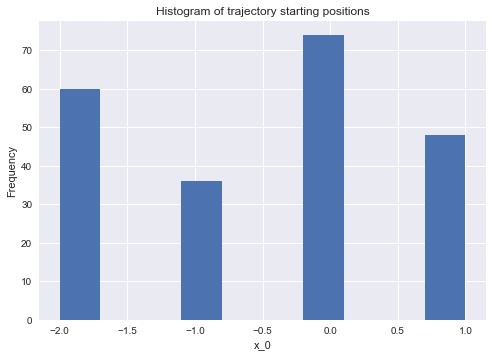

In [6]:
abc_results.plot_distribution()

In [14]:
mcs = MCSampler()
mc_results = mcs.solve(rw, MC_SAMPLES)
mc_results.expectation(), mc_results.variance()

/Users/zaf/development/better-sampling/StochasticProcess.py:135: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(self.prior.pdf(self.x_agent))


(0.11899313501144165, 2.658609512538684)

Consider that $X_0\sim \text{DiscreteUniform}(-c, c)$. The PMF of this distribution is given by 
$$p_{X_0}(x) = \{\frac{1}{2c} ~~ x \in [-c, c]; 0~~\text{otherwise}\}$$

Let $X_t\sim \text{Bern}(p)$. Since we are taking steps of size +1 or -1, let us define $S_t=2X_t - 1$ the distribution of $P_{S_t}(S_t=s) = P_{S_t}(2X_t-1 = s) = P_{X_t}(X_t = \frac{s+1}{2}) = \{ p ~~\text{if} \frac{s+1}{2}=1 ; 1-p ~~\text{if}\frac{s+1}{2}=0\}$

Possibly more importantly, the total number of steps taken is defined to be $S_T = \sum_{i=1}^T S_t$. What is this distribution?

$$P(S_T=s) = P(\sum_{i=1}^TS_t=s)= P\big(\sum_{i=1}^T(2X_t-1)=s\big) = P\big(\sum_{i=1}^TX_t=\frac{s+T}{2}\big)$$

We know how $\sum_{i=1}^T X_t$ is distributed! It is Bernoulli. Therefore:

$$P(S_T=s)=P\big(\sum_{i=1}^TX_t=\frac{s+T}{2}\big)={T\choose\frac{s+T}{2}}p^{\frac{s+T}{2}}(1-p)^{T-\frac{s+T}{2}} ~\text{if}~0 \leq \frac{s+T}{2} \leq T$$

Let use define the total distance moved as $D=X_0 + S_T$. What is the posterior $P(X_0~|~D)$? Let us employ Bayes Rule:

$$P(X_0~|~D) = \frac{P(D~|~X_0)P(X_0)}{P(D)}$$

For now let us just compute the terms at the top. We already know $P(X_0)$, so let's focus on $P(D~|~X_0)$:

$$P(D=d~|~X_0=x)\propto P(X_0 + S_T = d~|~X_0=x) = P(S_T = d - x~|~X_0=x)$$
$$P(S_T = d - x~|~X_0=x) = P(S_T = d-x)$$

Therefore our posterior is:

$$P_{D|X_0}(d,x) \propto P_{S_T}(d-x)P_{X_0}(x)$$
$$P_{D|X_0}(d,x) \propto \frac{1}{2c}{T\choose\frac{d-x+T}{2}}p^{\frac{d-x+T}{2}}(1-p)^{T-\frac{d-x+T}{2}}~\text{if}~x\in[-c, c]~ 0 \leq \frac{d-x+T}{2} \leq T$$

In [7]:
from scipy.misc import comb
c = 2
p = 0.5
T = 100
ending_position = rw.xT[0]
def pdf(d,x):
    term = int(0.5*(d-x+T))
#     print(term)
    if not(term <= T and term >= 0 and x <= c and x >= -c):
#         print('out of range')
        return 0
    else:
        return (1/2*c)*comb(T, term)*p**(term)*(1-p)**(T-term)

Text(0.5,1,'Posterior Distribution')

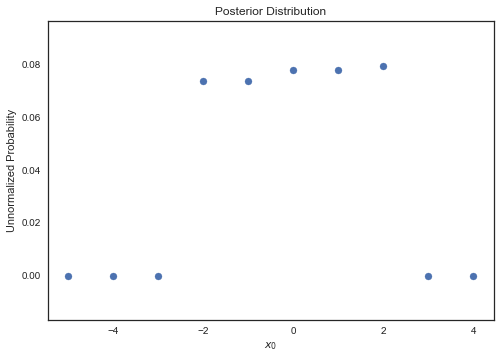

In [8]:
sns.set_style('white')
plt.scatter(np.arange(-5, 5), [pdf(rw.xT, x) for x in np.arange(-5, 5)])
plt.xlabel(r"$x_0$")
plt.ylabel('Unnormalized Probability')
plt.title('Posterior Distribution')